<a href="https://colab.research.google.com/github/thai94/d2l/blob/main/4.multilayer_perceptrons/4_5_weight_decay_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils import data as data

In [111]:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [112]:
def load_array(data_arrays, batch_size, is_train=True):
  dataset = data.TensorDataset(*data_arrays)
  return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [113]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)
test_data = synthetic_data(true_w, true_b, n_test)
test_iter = load_array(test_data, batch_size, is_train=False)

In [114]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [115]:
def l2_penalty(w):
  return torch.sum(w.pow(2)) / 2.0

In [116]:
def linreg(X, w, b):
    """The linear regression model."""
    return torch.matmul(X, w) + b

In [117]:
def squared_loss(y_hat, y):
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [118]:
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [119]:
class Accumulator:
  def __init__(self, n):
    self.data = [0.0] * n
  
  def add(self, *args):
    self.data = [a + float(b) for a,b in zip(self.data, args)]

  def reset(self):
    self.data = [0.0] * len(self.data)
    
  def __getitem__(self, idx):
    return self.data[idx]

In [120]:
def evaluate_loss(net, data_iter, loss):
  metric = Accumulator(2)
  for X, y in data_iter:
    out = net(X)
    y = y.reshape(out.shape)
    l = loss(out, y)
    metric.add(l.sum(), l.numel())
  return metric[0] / metric[1]

In [121]:
w, b = init_params()
def train(lambd):
  net, loss = lambda X: linreg(X, w, b), squared_loss
  num_epochs, lr = 100, 0.003

  x = []
  train_loss = []
  test_loss = []
  for epoch in range(num_epochs):
    for X, y in train_iter:
      l = loss(net(X), y) + lambd * l2_penalty(w)
      l.sum().backward()
      sgd([w, b], lr, batch_size)
    if (epoch + 1) % 5 == 0:
      x.append(epoch)
      train_loss.append(evaluate_loss(net, train_iter, loss))
      test_loss.append(evaluate_loss(net, test_iter, loss))
  plt.plot(x, train_loss, 'r')
  plt.plot(x, test_loss, 'b')
  plt.show()

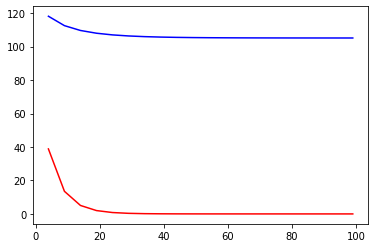

In [122]:
train(lambd=0)

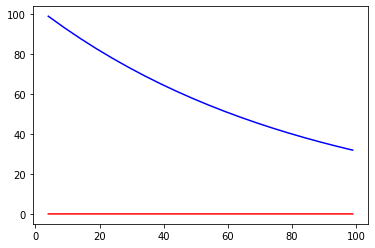

In [123]:
train(lambd=0.5)

In [124]:
def train_concise(wd):

  net = nn.Sequential(nn.Linear(num_inputs, 1))
  for param in net.parameters():
    param.data.normal_()
  loss = nn.MSELoss(reduction='none')
  num_epochs, lr = 100, 0.003
  trainer = torch.optim.SGD([{"params": net[0].weight, 'weight_decay': wd}, {"params": net[0].bias}], lr=lr)
  x = []
  train_loss = []
  test_loss = []
  for epoch in range(num_epochs):
    for X, y in train_iter:
      trainer.zero_grad()
      l = loss(net(X), y)
      l.mean().backward()
      trainer.step()
    if (epoch + 1) % 5 == 0:
      x.append(epoch)
      train_loss.append(evaluate_loss(net, train_iter, loss))
      test_loss.append(evaluate_loss(net, test_iter, loss))
  plt.plot(x, train_loss, 'r')
  plt.plot(x, test_loss, 'b')
  plt.show()

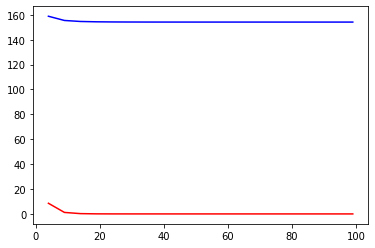

In [125]:
train_concise(0)

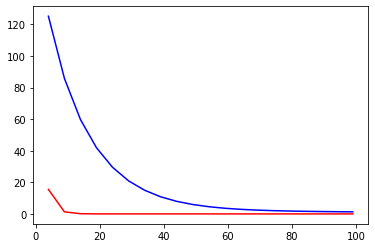

In [126]:
train_concise(3)